# May 2nd, 2022 (global order or not? -- prelim)

**Motivation**: in Group, find_best_mappings() is used to get the best permutations across seeds and runs.  Would it make sense to use global ordering or not? <br>

In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from numpy.ma import masked_where as mwh
from scipy.ndimage import gaussian_filter
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')
%matplotlib inline

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
fig_dir = pjoin(git_dir, 'jb-Ca-fMRI/figs')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = pjoin(os.environ['HOME'], 'Documents/workspaces/lfr/binary_overlapping')


# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.fourier import *
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
def quick_show(tr1, tr2, vmin=0.1, vmax=None, figsize=(13.5, 4), cmap='magma'):
    num = max(len(tr1['proj-top']), len(tr2['proj-top']))
    fig, axes = create_figure(2, num, figsize)
    for i in range(num):

        ax = axes[0, i]
        if i >= len(tr1['proj-top']):
            ax.remove()
        else:
            ax.imshow(mwh(tr1['top'] == 0, tr1['top']), cmap='Greys_r')
            if np.nanmax(tr1['proj-top'][i]) > 1:
                _cmap = 'Accent_r'
                _vmax = None
            else:
                _cmap = cmap
                _vmax = vmax
            ax.imshow(mwh(tr1['proj-top'][i] < vmin, tr1['proj-top'][i]), cmap=_cmap, vmin=vmin, vmax=_vmax)

        ax = axes[1, i]
        if i >= len(tr2['proj-top']):
            ax.remove()
        else:
            ax.imshow(mwh(tr2['top'] == 0, tr2['top']), cmap='Greys_r')
            if np.nanmax(tr2['proj-top'][i]) > 1:
                _cmap = 'Accent_r'
                _vmax = None
            else:
                _cmap = cmap
                _vmax = vmax
            ax.imshow(mwh(tr2['proj-top'][i] < vmin, tr2['proj-top'][i]), cmap=_cmap, vmin=vmin, vmax=_vmax)

    remove_ticks(axes)
    plt.show()

## 128 * 3

In [3]:
mice = Mice((128, 3))
mice.setup_func_data('rest')

p = 25
props_base = {
    'perc': f'p{p}-sample',
    'num_k': None,
    'ordering': None,
    'dist_metric': None,
    'mice': mice,
    'task': 'rest',
    'graph_type': 'real',
    'verbose': False,
}
props_ca = {'mode': 'ca2', **props_base}
props_bo = {'mode': 'bold-lite', **props_base}

In [ ]:
%%time

looper = itertools.product(
    ['global', 'local', 'infer'],
    ['cosine', 'correlation', 'euclidean'],
)
all_k = list(range(4, 12)) + [15]
for ordering, metric in looper:
    for num_k in all_k:
        _props = props_ca.copy()
        _props['num_k'] = num_k
        _props['ordering'] = ordering
        _props['dist_metric'] = metric
        gr_ca = Group(**_props).fit_group(force=True)
        _props = props_bo.copy()
        _props['num_k'] = num_k
        _props['ordering'] = ordering
        _props['dist_metric'] = metric
        gr_bo = Group(**_props).fit_group(force=True)

### K = 8, p = 25

In [3]:
mice = Mice((128, 3))
mice.setup_func_data('rest')

mako = sns.color_palette('mako', as_cmap=True)
rocket = sns.color_palette('rocket', as_cmap=True)
pal = {'ca2': mako(0.6), 'bold-lite': rocket(0.6)}

num_k, p = 8, 25
perc = f'p{p}-sample'
ordering = 'infer'
metric = 'cosine'
props_base = {
    'perc': perc,
    'num_k': num_k,
    'ordering': ordering,
    'dist_metric': metric,
    'mice': mice,
    'task': 'rest',
    #'metric': 'pearson',
    #'match_using': 'gam',
    #'match_metric': 'euclidean',
    'graph_type': 'real',
    'verbose': False,
}
props_ca = {'mode': 'ca2', **props_base}
props_bo = {'mode': 'bold-lite', **props_base}

In [4]:
%%time

gr_ca = Group(**props_ca).fit_group(force=True)
gr_bo = Group(**props_bo).fit_group(force=True)

CPU times: user 16min 12s, sys: 19.8 s, total: 16min 32s
Wall time: 2min 15s


In [5]:
gr_ca = Group(**props_ca).fit_group()
gr_bo = Group(**props_bo).fit_group()

In [6]:
gr_ca.pi = bn.nanmean(bn.nanmean(bn.nanmean(bn.nanmean(gr_ca.run_pi, 3), 2), 1), 0)
gr_bo.pi = bn.nanmean(bn.nanmean(bn.nanmean(bn.nanmean(gr_bo.run_pi, 3), 2), 1), 0)

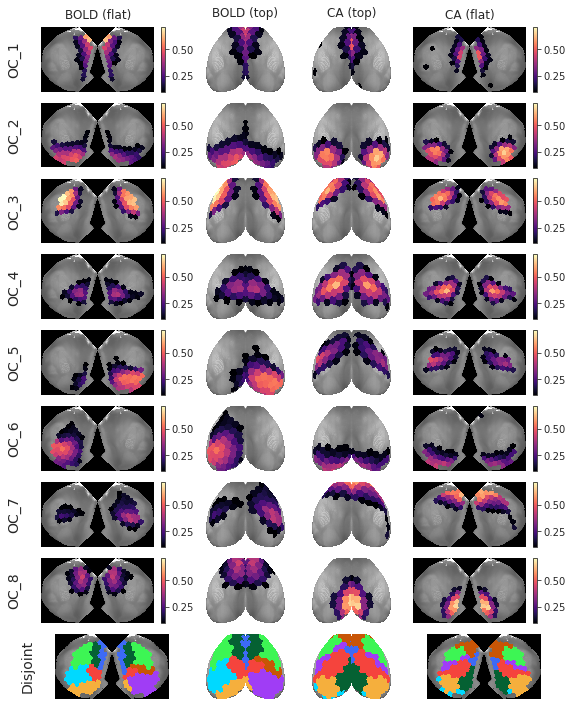

In [7]:
proj_bo = gr_bo.project_vec()
proj_ca = gr_ca.project_vec()

_ = gr_ca.show(
    proj_1=proj_bo,
    proj_2=proj_ca,
    cmaps=('magma',) * 2,
    labels=('BOLD', 'CA'),
    fix_cmap=True,
    min_thres=0.1,
)

In [8]:
idx_1, idx_2 = 4, 5
pi = gr_bo.pi.copy()

pi[idx_1][pi[idx_1] < 0.15] = 0
pi[idx_2][pi[idx_2] < 0.15] = 0
pi[idx_1] += pi[idx_2]
pi = pi[np.delete(range(num_k), idx_2)]
pi = pi / np.nansum(pi, -2, keepdims=True)
# pi = pi[[0, 5, 2, 3, 6, 9, 4, 7, 8, 1]]
tr = gr_bo.project_vec(pi)
tr = gr_bo.trim2d(tr)

In [9]:
pi_ca = gr_ca.pi# [[0, 1, 2, 4, 3]]
tr_ca = gr_ca.project_vec(pi_ca)
tr_ca = gr_ca.trim2d(tr_ca)

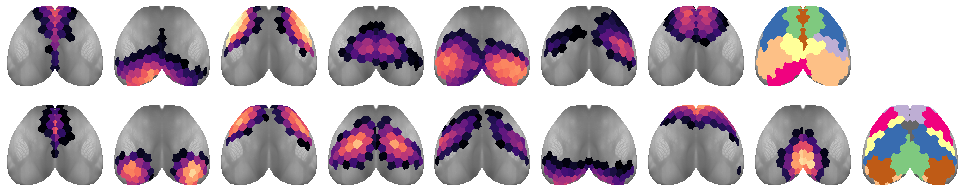

In [10]:
quick_show(tr, tr_ca, vmin=0.12, vmax=0.7, figsize=(13.5, 3))

In [11]:
sim_cos = dist2sim(sp_dist.cdist(pi, pi_ca, 'cosine'))
sim_corr = dist2sim(sp_dist.cdist(pi, pi_ca, 'correlation'))

sim_corr.diagonal().mean(), sim_cos.diagonal().mean()

(0.39040706473020675, 0.6849299290658745)

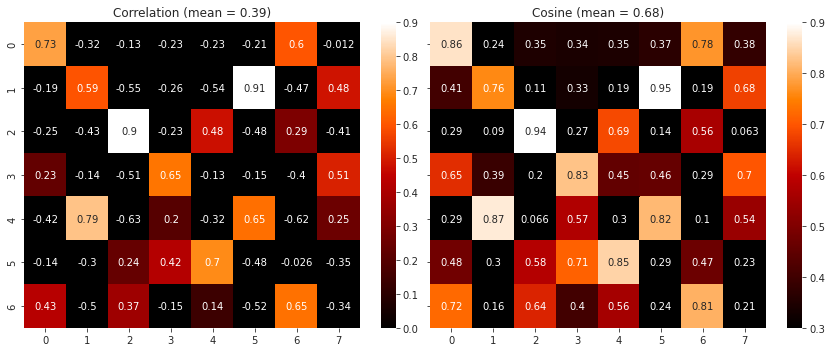

In [12]:
fig, axes = create_figure(1, 2, (12, 5.), 'all', 'all')
sns.heatmap(sim_corr, cmap='gist_heat', annot=True, vmin=0, vmax=0.9, ax=axes[0])
sns.heatmap(sim_cos, cmap='gist_heat', annot=True, vmin=0.3, vmax=0.9, ax=axes[1])
axes[0].set_title(f'Correlation (mean = {sim_corr.diagonal().mean():0.2f})')
axes[1].set_title(f'Cosine (mean = {sim_cos.diagonal().mean():0.2f})')
plt.show()

In [13]:
gmap = find_best_match(sim_cos, global_order=False)
gmap = list(gmap.values())
gmap += [i for i in range(len(pi_ca)) if i not in gmap]
gmap

[0, 5, 2, 3, 1, 4, 6, 7]

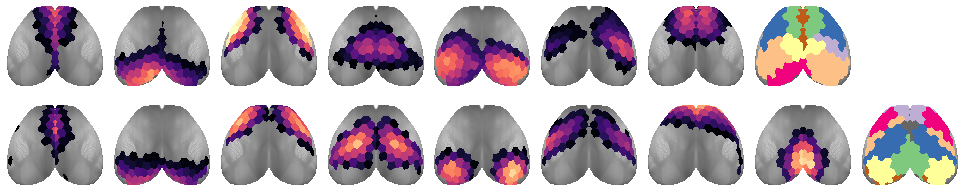

In [14]:
quick_show(
    tr,
    gr_ca.trim2d(gr_ca.project_vec(pi_ca[gmap])),
    vmin=0.1,
    vmax=0.7,
    figsize=(13.5, 3),
)

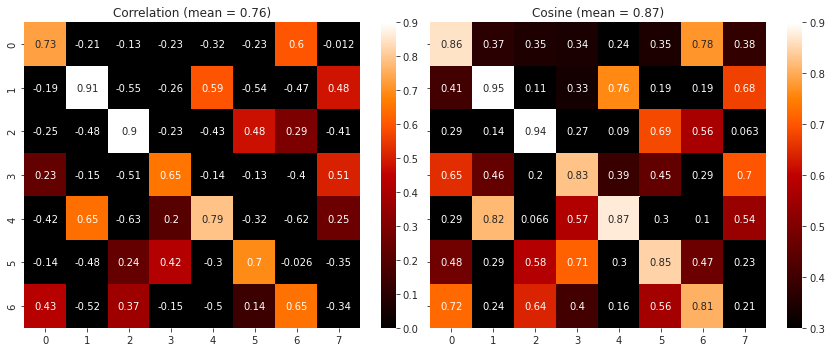

In [15]:
sim_cos = dist2sim(sp_dist.cdist(pi, pi_ca[gmap], 'cosine'))
sim_corr = dist2sim(sp_dist.cdist(pi, pi_ca[gmap], 'correlation'))

fig, axes = create_figure(1, 2, (12, 5.), 'all', 'all')
sns.heatmap(sim_corr, cmap='gist_heat', annot=True, vmin=0, vmax=0.9, ax=axes[0])
sns.heatmap(sim_cos, cmap='gist_heat', annot=True, vmin=0.3, vmax=0.9, ax=axes[1])
axes[0].set_title(f'Correlation (mean = {sim_corr.diagonal().mean():0.2f})')
axes[1].set_title(f'Cosine (mean = {sim_cos.diagonal().mean():0.2f})')
plt.show()

In [16]:
sim_cos.diagonal()

array([0.86492164, 0.9517285 , 0.93758593, 0.82753353, 0.87495475,
       0.84823524, 0.80803116])

## Now explore effect of global order

In [21]:
def _do_it(self):
    accepted_runs, good_global = self._good_nodes(freq_q=0.9)
    sv_attr = f"{self.sv_props['match_using']}_all"
    data = [
        getattr(sv, sv_attr).reshape(-1, len(self.n2l))
        for k, sv in self.svinets.items()
        if k in accepted_runs
    ]
    data = np.concatenate(data)
    nonan = np.where(np.isnan(data).sum(0) == 0)[0]
    centroids = np.zeros((self.num_k, data.shape[-1]))
    _centroids, _ = fit_kmeans(
        data=data[:, nonan],
        n_clusters=self.num_k,
        match_metric=self.sv_props['match_metric'],
        random_state=self.mice.cfg.random_state,
    )
    centroids[:, nonan] = _centroids

    global_mapping = self.align_centroid_to_structs(
        pi_mv=centroids,
        metric='cosine',
        global_order=False,
    )
    centroids = centroids[global_mapping]
    
    ner = Normalizer()
    perms = {}
    for k, sv in self.svinets.items():
        good = getattr(sv, self.sv_props['match_using'])
        good = np.where(np.isnan(good).sum(0) == 0)[0]
        good = set(good).intersection(good_global)
        good = np.array(sorted(good))
        _x = getattr(sv, sv_attr)[..., good]
        _x = np.where(~np.isnan(_x), _x, 0.0)
        data_clean = {
            i: ner.fit_transform(_x[i])
            for i in range(len(_x))
        }
        perms[k] = find_best_mappings(
            data=data_clean,
            centroids=ner.fit_transform(centroids[:, good]),
            match_metric=self.dist_metric,
            global_order=self.global_order,
        )
    self.perms = perms
    permuted = self._apply_perms()
    
    pi_all = []
    for key, item in permuted.items():
        pi_all.append(np.nanmean(item['pi'], 0, keepdims=True))
    pi_all = np.concatenate(pi_all)
    pi = bn.nanmean(pi_all, 0)
    
    tr = gr_ca.project_vec(pi)
    tr = gr_ca.trim2d(tr)
    
    return pi, tr

In [22]:
results_ca = {}
results_bo = {}
for ordering in tqdm(['global', 'local', 'infer']):
    for metric in tqdm(['cosine', 'correlation', 'euclidean'], leave=False):
        _props = props_ca.copy()
        _props['ordering'] = ordering
        _props['dist_metric'] = metric
        gr_ca = Group(**_props)
        results_ca[f"{ordering}_{metric}"] = _do_it(gr_ca)
        
        _props = props_bo.copy()
        _props['ordering'] = ordering
        _props['dist_metric'] = metric
        gr_bo = Group(**_props)
        results_bo[f"{ordering}_{metric}"] = _do_it(gr_bo)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Warning, '8' nans detected . . . filling with ones

Warning, '8' nans detected . . . filling with ones

Warning, '8' nans detected . . . filling with ones

  0%|          | 0/3 [00:00<?, ?it/s]

Warning, '8' nans detected . . . filling with ones

Warning, '8' nans detected . . . filling with ones

Warning, '8' nans detected . . . filling with ones

  0%|          | 0/3 [00:00<?, ?it/s]

Warning, '8' nans detected . . . filling with ones

Warning, '8' nans detected . . . filling with ones

Warning, '8' nans detected . . . filling with ones

global cosine

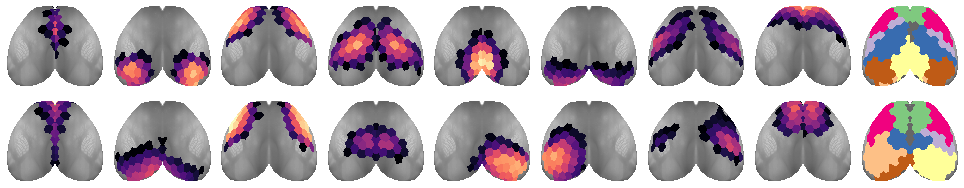

local cosine

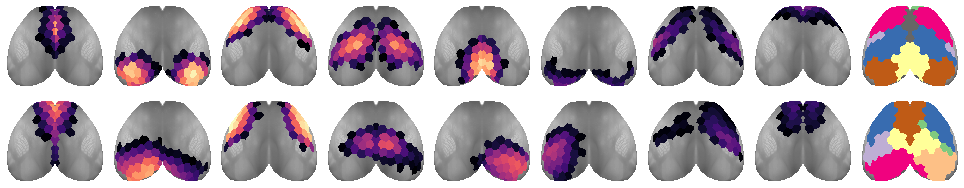

infer cosine

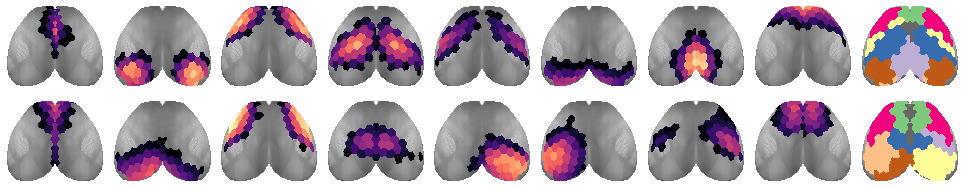

global correlation

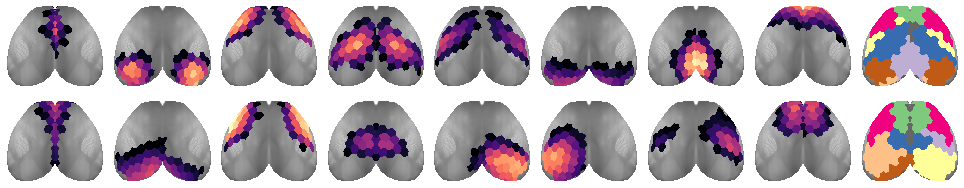

local correlation

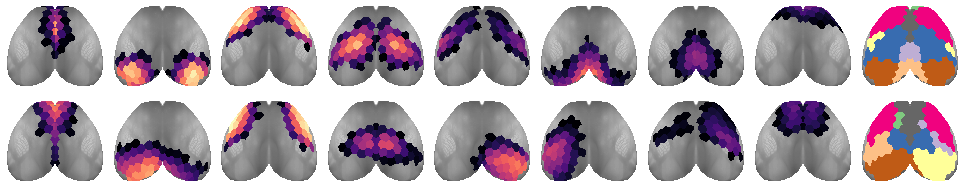

infer correlation

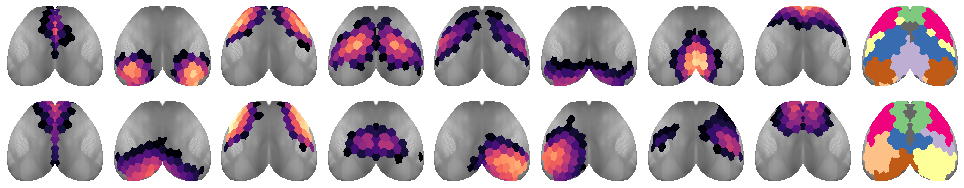

global euclidean

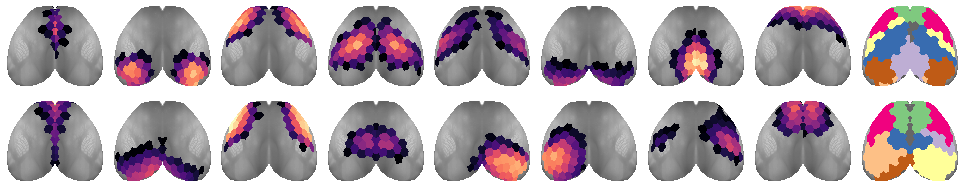

local euclidean

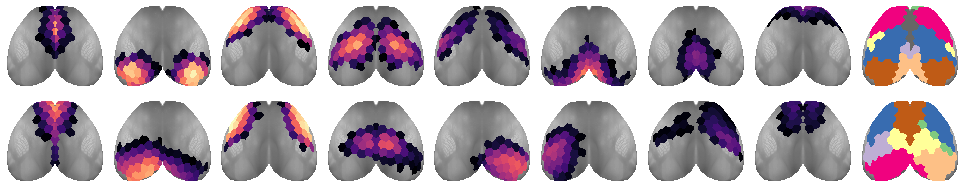

infer euclidean

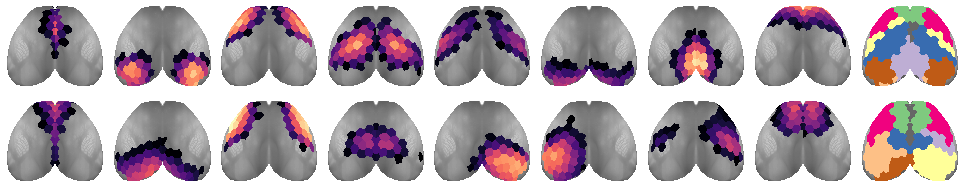

In [84]:
for metric in ['cosine', 'correlation', 'euclidean']:
    for ordering in ['global', 'local', 'infer']:
        pi_ca, tr_ca = results_ca[f"{ordering}_{metric}"]
        pi_bo, tr_bo = results_bo[f"{ordering}_{metric}"]
        print(ordering, metric)
        quick_show(tr_ca, tr_bo, 0.13, 0.7, (13.5, 3))

In [67]:
vmin_ent = {}
vmax_ent = {}
entropy = {}
dlist = []
for ordering in ['global', 'local', 'infer']:
    for metric in ['cosine', 'correlation', 'euclidean']:
        lbl = f"{ordering}_{metric}"
        pi_ca, tr_ca = results_ca[lbl]
        pi_bo, tr_bo = results_bo[lbl]
        h = np.concatenate([
            sp_stats.entropy(pi_ca, axis=-2).reshape(1, -1),
            sp_stats.entropy(pi_bo, axis=-2).reshape(1, -1),
        ]) / np.log(num_k)
        vmin_ent[lbl] = np.nanmin(h[h.nonzero()])
        vmax_ent[lbl] = np.nanmax(h[h.nonzero()])
        
        tr = gr_ca.project_vec(h, add_disjoint=False)
        entropy[lbl] = gr_ca.trim2d(tr)
        
        # h sym score
        h_sym = gr_ca.pi_symmetry_score(h, decimals=10)[0]
        dlist.append({
            'ordering': [ordering] * 2,
            'metric': [metric] * 2,
            'mode': ['ca2', 'bold'],
            'label': ['h_sym'] * 2,
            'oc_idx': [-100] * 2,
            'score': [h_sym[1], h_sym[2]],
        })
        
        # pi sym score: CA2
        ovp, disj = gr_ca.pi_symmetry_score(pi_ca, decimals=10)
        dlist.append({
            'ordering': [ordering] * len(ovp),
            'metric': [metric] * len(ovp),
            'mode': ['ca2'] * len(ovp),
            'label': ['ovp'] * len(ovp),
            'oc_idx': ovp.keys(),
            'score': ovp.values(),
        })
        dlist.append({
            'ordering': [ordering] * len(disj),
            'metric': [metric] * len(disj),
            'mode': ['ca2'] * len(disj),
            'label': ['disj'] * len(disj),
            'oc_idx': disj.keys(),
            'score': disj.values(),
        })

        # pi sym score: BOLD
        ovp, disj = gr_bo.pi_symmetry_score(pi_bo, decimals=10)
        dlist.append({
            'ordering': [ordering] * len(ovp),
            'metric': [metric] * len(ovp),
            'mode': ['bold'] * len(ovp),
            'label': ['ovp'] * len(ovp),
            'oc_idx': ovp.keys(),
            'score': ovp.values(),
        })
        dlist.append({
            'ordering': [ordering] * len(disj),
            'metric': [metric] * len(disj),
            'mode': ['bold'] * len(disj),
            'label': ['disj'] * len(disj),
            'oc_idx': disj.keys(),
            'score': disj.values(),
        })
        
df = pd.DataFrame(merge_dicts(dlist))

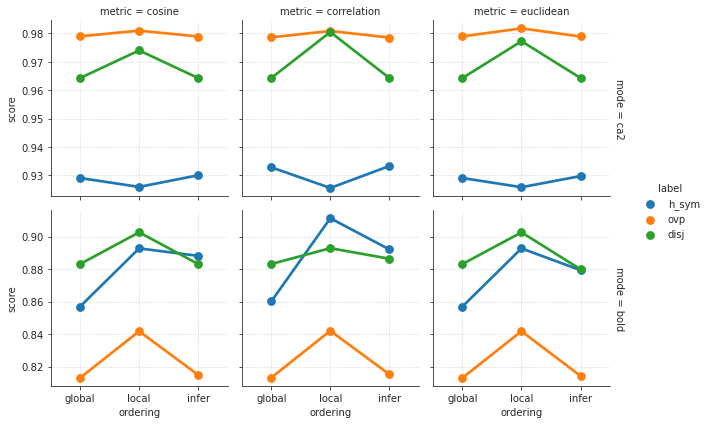

In [83]:
fg = sns.catplot(
    data=df.loc[df['oc_idx'].isin([-1, -100])],
    kind='point',
    x='ordering',
    col='metric',
    row='mode',
    y='score',
    hue='label',
    sharey='row',
    margin_titles=True,
    height=3,
)
_ = add_grid(fg.axes)
plt.show()

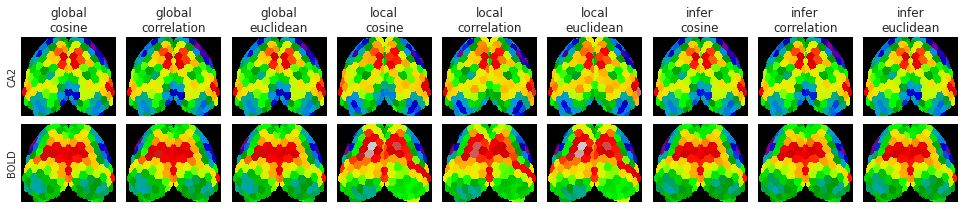

In [85]:
kws = {
    'cmap': 'nipy_spectral',
    'vmin': min(vmin_ent.values()),
    'vmax': max(vmax_ent.values()),
}
fig, axes = create_figure(2, 9, (13.5, 3.1))
for i, (lbl, tr) in enumerate(entropy.items()):
    a, b = lbl.split('_')
    axes[0, i].set_title(f"{a}\n{b}")
    for j in range(2):
        ax = axes[j, i]
        ax.imshow(tr['proj-top'][j], **kws)
axes[0, 0].set_ylabel('CA2')
axes[1, 0].set_ylabel('BOLD')
remove_ticks(axes)

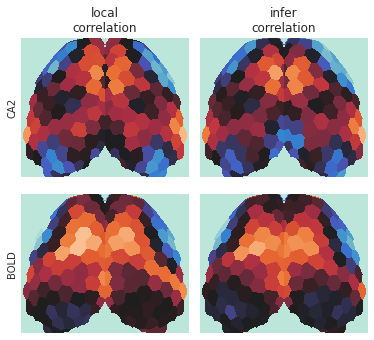

In [95]:
kws = {
    'cmap': 'icefire',
    'vmin': min(vmin_ent.values()),
    'vmax': max(vmax_ent.values()),
}
fig, axes = create_figure(2, 2, (5.3, 5))

a, b = 'local', 'correlation'
tr = entropy[f"{a}_{b}"]
axes[0, 0].set_title(f"{a}\n{b}")
for j in range(2):
    ax = axes[j, 0]
    ax.imshow(tr['proj-top'][j], **kws)
    
a, b = 'infer', 'correlation'
tr = entropy[f"{a}_{b}"]
axes[0, 1].set_title(f"{a}\n{b}")
for j in range(2):
    ax = axes[j, 1]
    ax.imshow(tr['proj-top'][j], **kws)
    
axes[0, 0].set_ylabel('CA2')
axes[1, 0].set_ylabel('BOLD')
remove_ticks(axes)